In [ ]:
%load_ext autoreload
%autoreload 2

In [22]:
# Step 1: Import necessary libraries
from moabb.datasets import BI2012
from moabb.paradigms import P300
import matplotlib.pyplot as plt
import mne
import numpy as np

# import matplotlib
# matplotlib.use('TkAgg')

import mne
from mne import Epochs, compute_raw_covariance
from mne.preprocessing import Xdawn

from power import field_root_mean_square, plot_fmrs

In [23]:
%matplotlib widget

In [84]:
dataset.subject_list

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25]

In [24]:
dataset= BI2012()
raw = dataset.get_data(subjects=[8])


/nethome/costamai/myenvs/main_env/lib/python3.10/site-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/nethome/costamai/myenvs/main_env/lib/python3.10/site-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
100%|█████████████████████████████████████| 25.8M/25.8M [00:00<00:00, 22.9GB/s]
SHA256 hash of downloaded file: b519bb58560635df485efc24a0941aea5cdce6d53f30873e3f753188802161a2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


In [83]:
raw_.ch_names

['F7',
 'F3',
 'F4',
 'F8',
 'T7',
 'C3',
 'Cz',
 'C4',
 'T8',
 'P7',
 'P3',
 'Pz',
 'P4',
 'P8',
 'O1',
 'O2']

In [86]:
raw[8]['0']['0training']

<RawArray | 16 x 46320 (361.9 s), ~5.7 MB, data loaded>

In [25]:
raw_ = raw[8]['0']['0training']

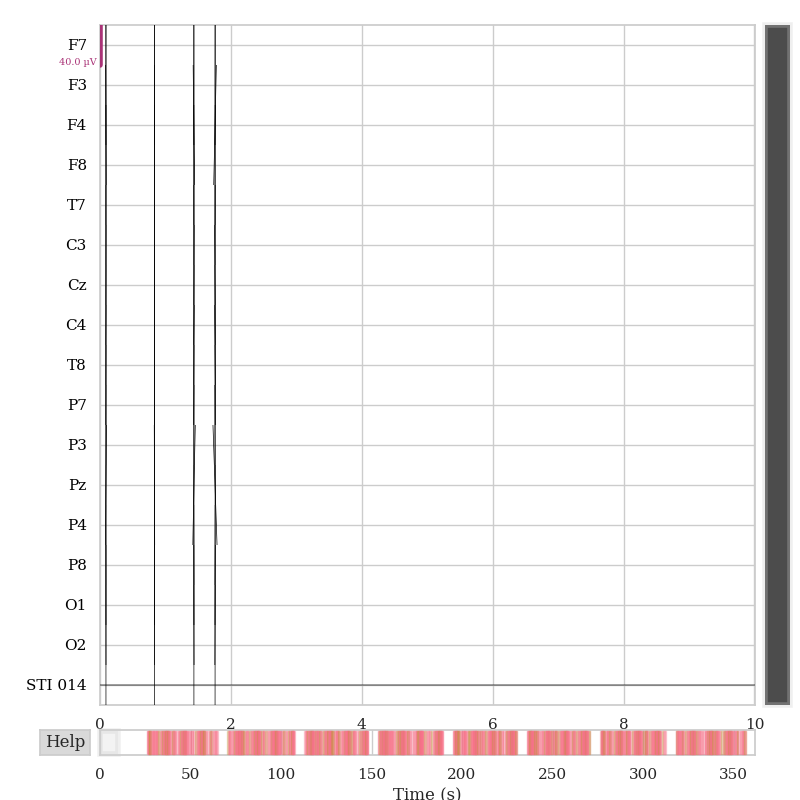

In [26]:
raw_.plot();

In [31]:
raw_.pick_types(eeg=True)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<RawArray | 16 x 46320 (361.9 s), ~5.7 MB, data loaded>

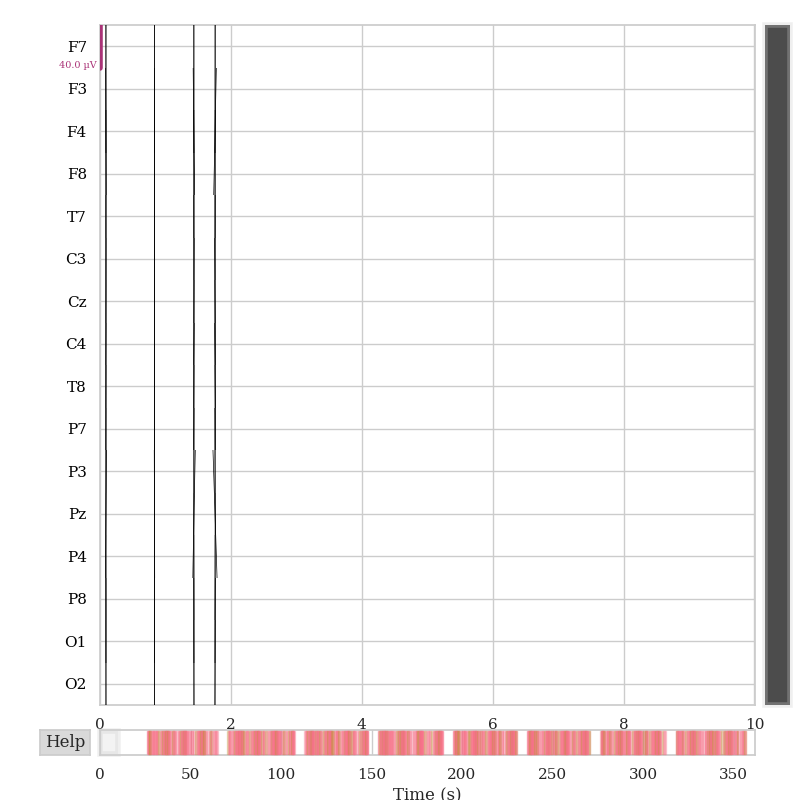

In [33]:
raw_.plot();

Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


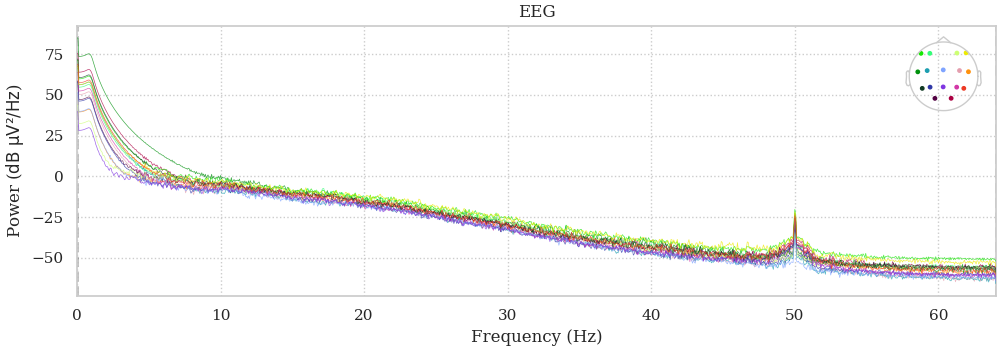

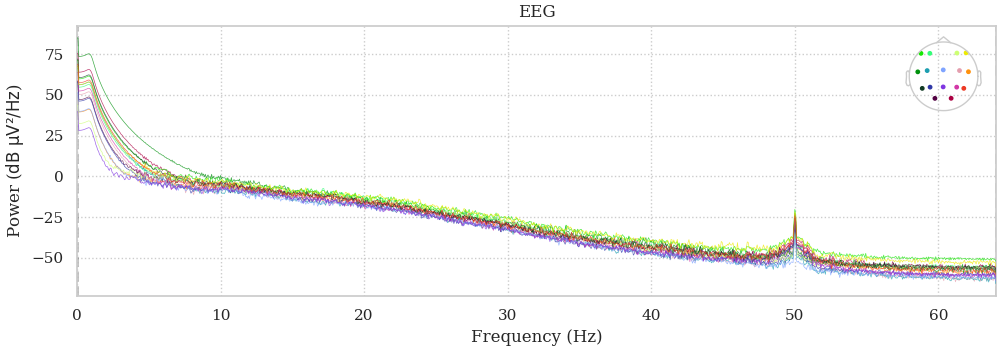

In [36]:
raw_.compute_psd().plot();
 

In [42]:
# Step 3: Define the paradigm (task)
# Motor Imagery paradigm is common in BCI research
paradigm = P300()

# Step 4: Fetch data for specific subjects
# You can specify subjects here; for now, we use two subjects as an example
subject_ids = dataset.subject_list[:1]
raw_epochs, labels, metadata = paradigm.get_data(dataset=dataset, subjects=subject_ids, return_epochs=True)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Adding metadata with 3 columns
Adding metadata with 3 columns
768 matching events found
No baseline correction applied


/nethome/costamai/myenvs/main_env/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 768 events (all good), 0 – 1 s (baseline off), ~12.1 MB, data loaded,
 'Target': 128
 'NonTarget': 640>
  warn(f"warnEpochs {epochs}")
/nethome/costamai/myenvs/main_env/lib/python3.10/site-packages/moabb/paradigms/base.py:350: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)


In [45]:
raw_epochs

<EpochsArray | 768 events (all good), 0 – 1 s (baseline off), ~12.1 MB, data loaded, with metadata,
 'Target': 128
 'NonTarget': 640>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


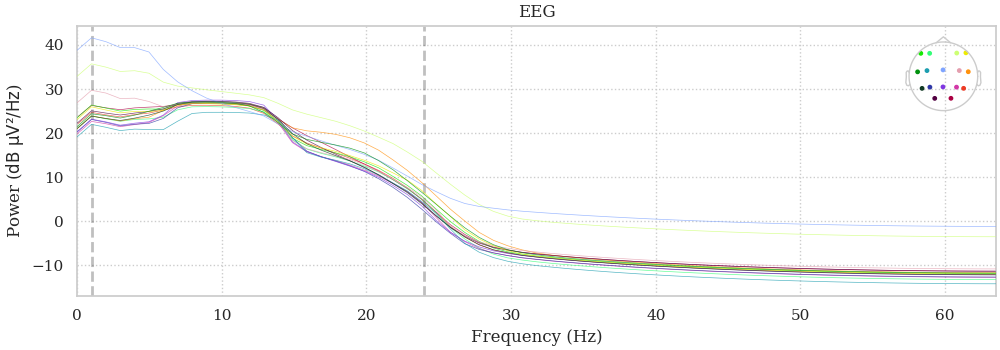

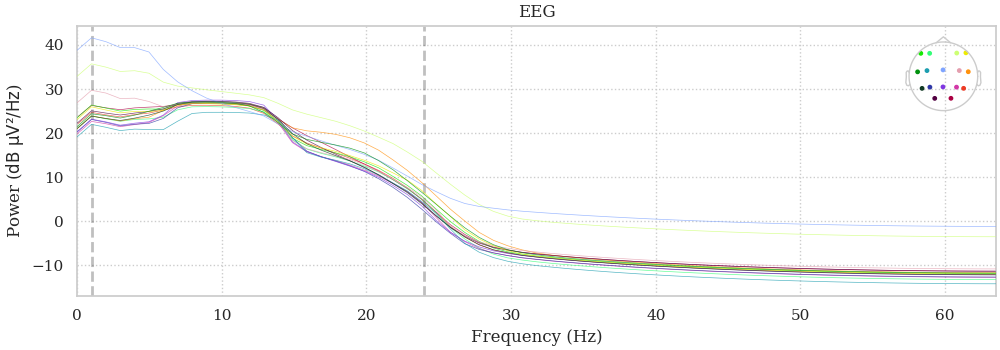

In [49]:
raw_epochs.plot_psd();

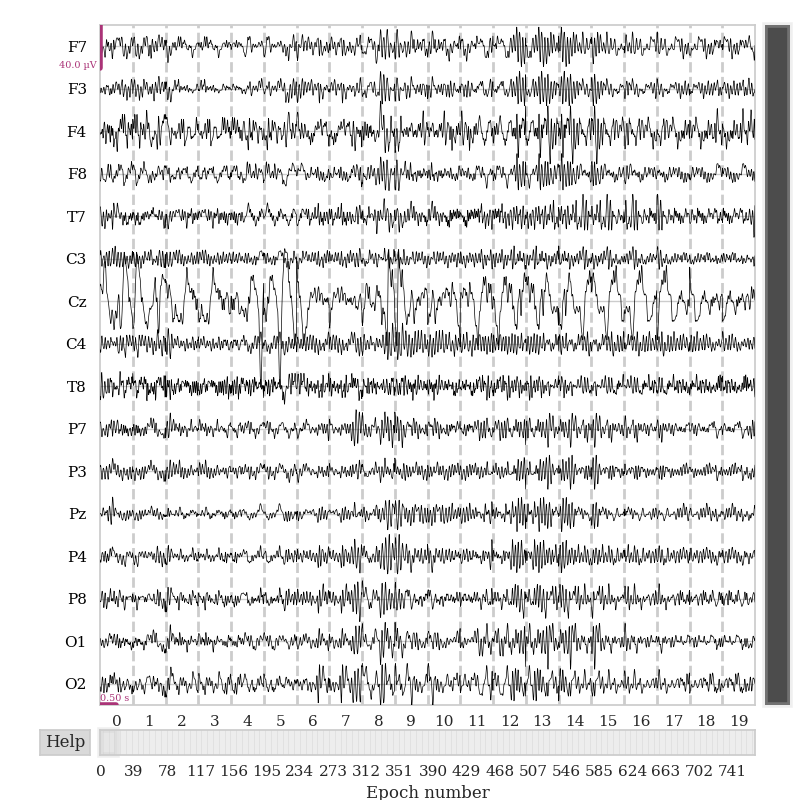

In [51]:
raw_epochs.plot();

In [55]:
raw_epochs

<EpochsArray | 768 events (all good), 0 – 1 s (baseline off), ~12.1 MB, data loaded, with metadata,
 'Target': 128
 'NonTarget': 640>

In [59]:
import copy

In [64]:
epochs_target = copy.deepcopy(raw_epochs['Target'].average())

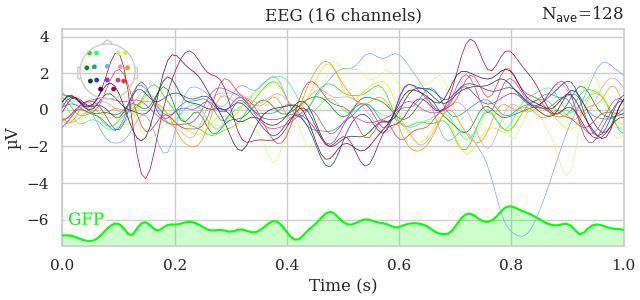

In [71]:
epochs_target.plot(gfp=True);

In [74]:
type(raw_epochs), type(epochs_target)

(mne.epochs.EpochsArray, mne.evoked.EvokedArray)

In [ ]:
epochs

In [79]:
epochs_data, epochs_info = epochs_target.get_data()., epochs_target.info
mne.EpochsArray(epochs_data, epochs_info).plot()

ValueError: Data must be a 3D array of shape (n_epochs, n_channels, n_samples)

In [27]:
raw.pick(["eeg"]).load_data()

<RawArray | 16 x 46804 (365.6 s), ~5.7 MB, data loaded>

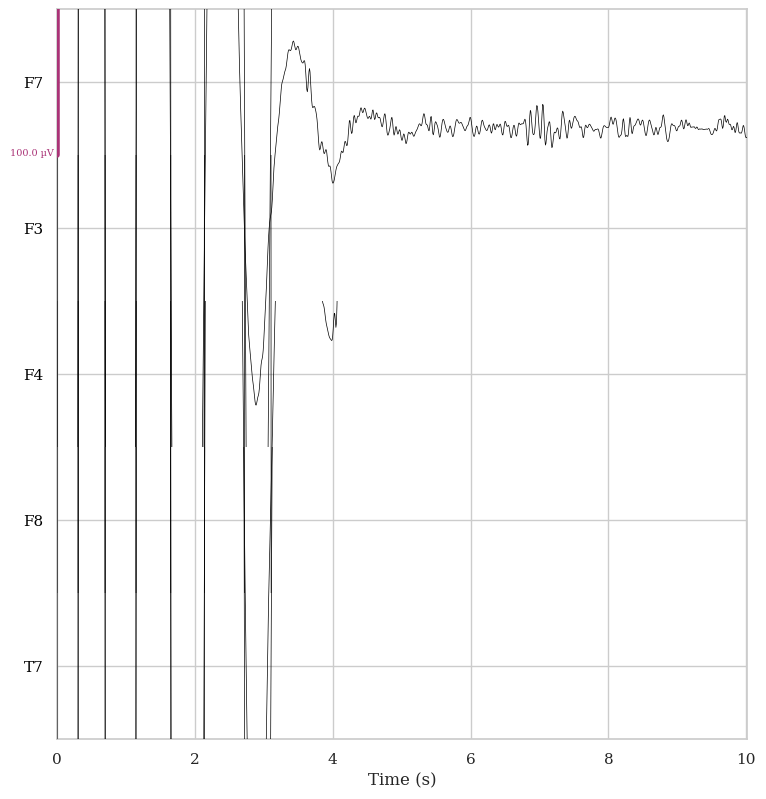

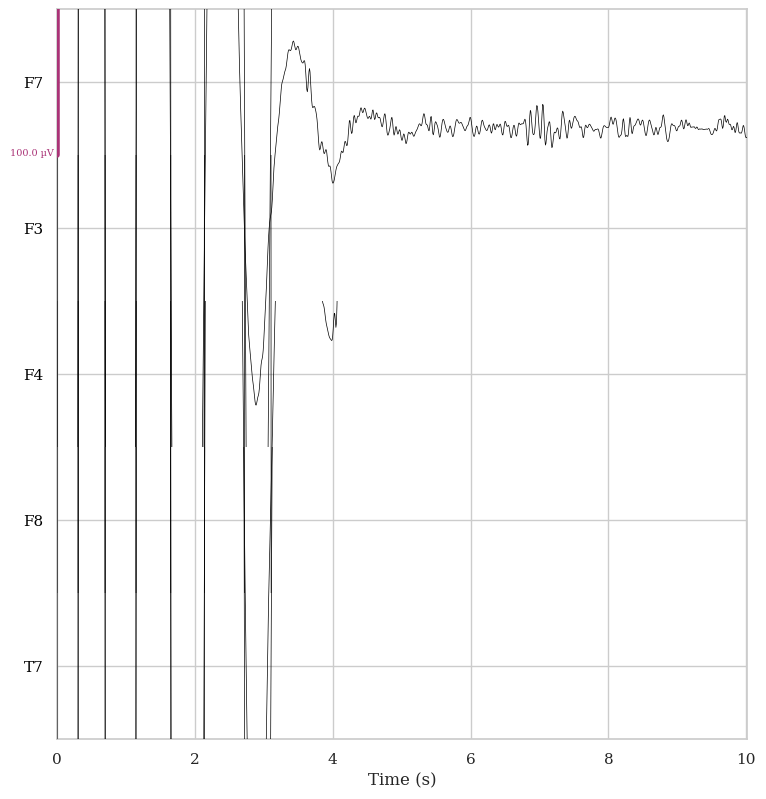

In [45]:
#see what it looked like before setting reference
for proj in (False, True):
    with mne.viz.use_browser_backend("matplotlib"):
        fig = raw.plot(
            n_channels=5, proj=proj, scalings=dict(eeg=50e-6), show_scrollbars=False
        );
    fig.subplots_adjust(top=0.9)  # make room for title
    ref = "Average" if proj else "No"
    fig.suptitle(f"{ref} reference", size="xx-large", weight="bold")

In [28]:
epochs = mne.Epochs(raw,  baseline=None, preload=True)

Used Annotations descriptions: ['NonTarget', 'Target']
Ignoring annotation durations and creating fixed-duration epochs around annotation onsets.
Not setting metadata
768 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 768 events and 91 original time points ...
0 bad epochs dropped


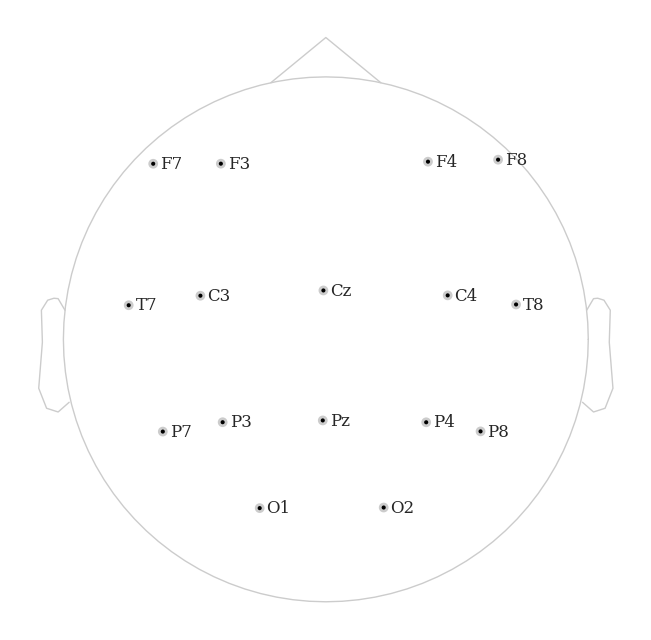

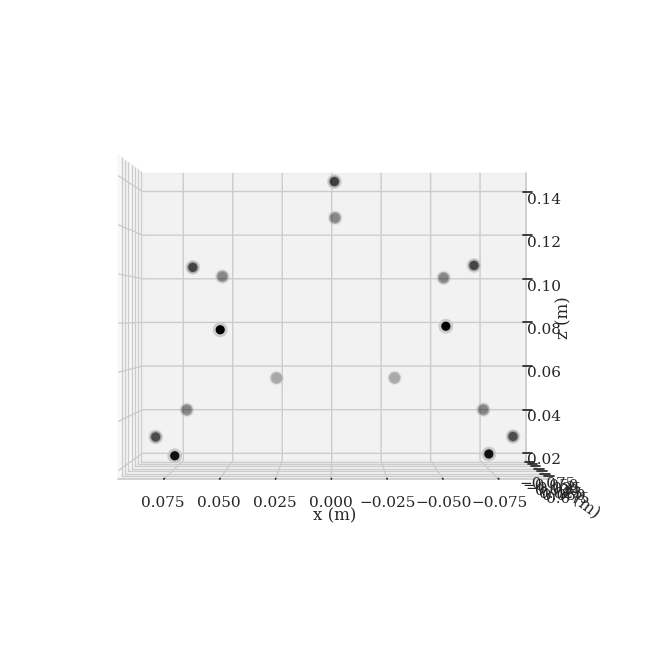

In [29]:
epochs.plot_sensors(show_names=True)
fig = epochs.plot_sensors("3d")

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


/nethome/costamai/myenvs/main_env/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


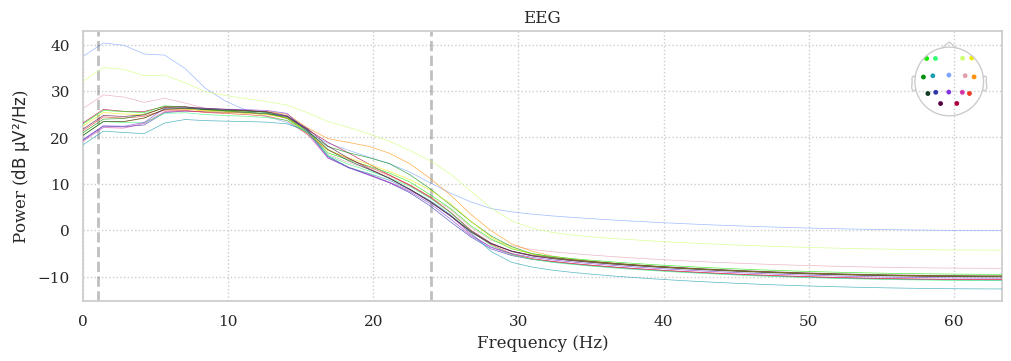

In [30]:
epochs.compute_psd().plot();

In [31]:
epochs

<Epochs | 768 events (all good), -0.203 – 0.5 s (baseline off), ~8.6 MB, data loaded,
 'NonTarget': 640
 'Target': 128>

In [32]:
np.max(epochs.get_data()[0].ravel()) , np.min(epochs.get_data()[0].ravel())
#data is in microvolt

(3.746142720350568e-05, -2.6691150633001707e-05)

In [33]:
#reject epochs if a channel amplitude exceeds max value
reject_criteria = dict(eeg=100e-6)  # 100 µV
epochs.drop_bad(reject=reject_criteria)

# import copy
# ep = copy.deepcopy(epochs)
# ep.drop_bad(reject=reject_criteria)

    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecti

<Epochs | 620 events (all good), -0.203 – 0.5 s (baseline off), ~6.9 MB, data loaded,
 'NonTarget': 514
 'Target': 106>

In [34]:
len(epochs["Target"])

106

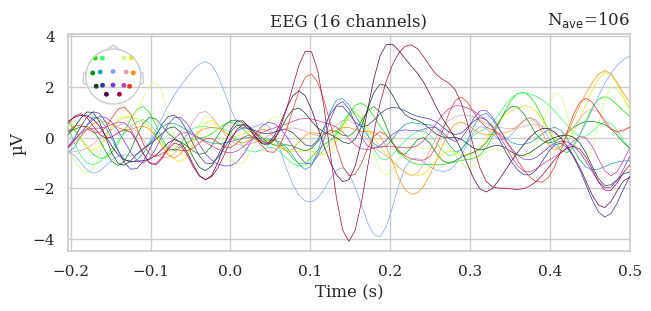

In [35]:
target = epochs["Target"].average()
fig1 = target.plot();

No projector specified for this dataset. Please consider the method self.add_proj.


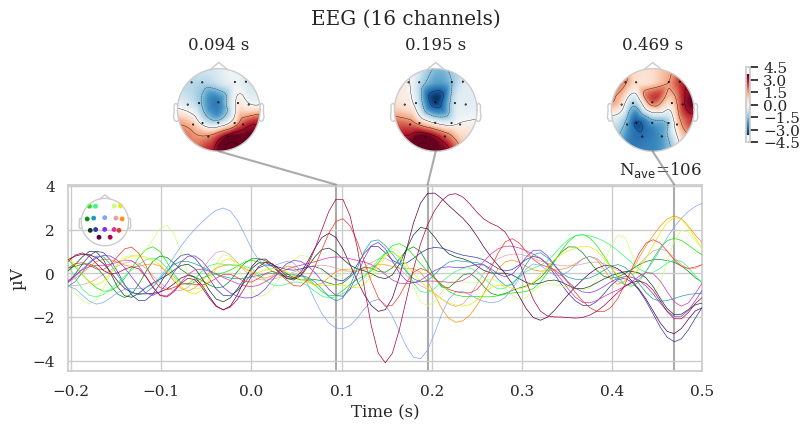

In [36]:
#see topomapson peak points together with butterflies plots 
target.plot_joint();

[Text(0.5, 0, 'Time (ms)'),
 Text(0, 0.5, 'GFP (µV)'),
 Text(0.5, 1.0, 'Global Field Power')]

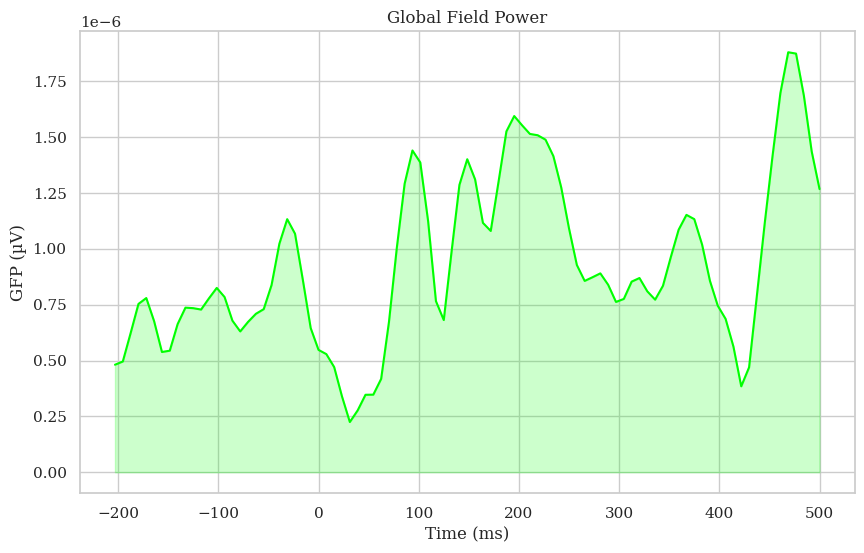

In [37]:
# Calculate Global Field Power and plot it with reference points
gfp = target.data.std(axis=0, ddof=0)

# Visualize GFP
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(target.times * 1000, gfp , color="lime")
ax.fill_between(target.times * 1000, gfp, color="lime", alpha=0.2)
ax.set(xlabel="Time (ms)", ylabel="GFP (µV)", title="Global Field Power")

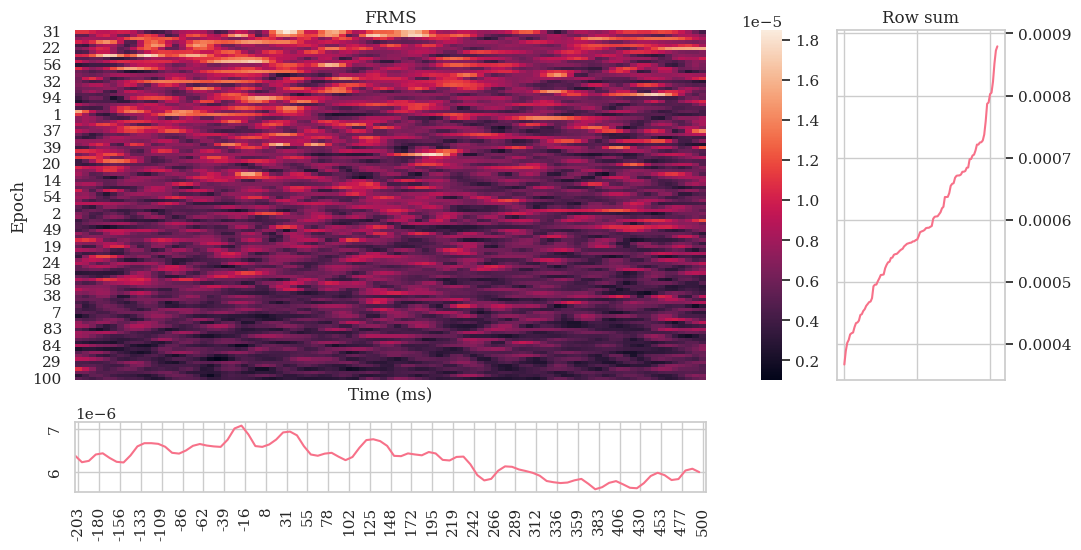

In [38]:
plot_fmrs(field_root_mean_square(epochs["Target"]))

## XDAWN Denoising
XDAWN filters are trained from epochs, signal is projected in the sources space and then projected back in the sensor space using only the first two XDAWN components. The process is similar to an ICA, but is supervised in order to maximize the signal to signal + noise ratio of the evoked response

#### Warning 
As this denoising method exploits the known events to maximize SNR of the contrast between conditions it can lead to overfitting. To avoid a statistical analysis problem you should split epochs used in fit with the ones used in apply method.

In [39]:
# Estimates signal covariance
signal_cov = compute_raw_covariance(raw)

# Xdawn instance
xd = Xdawn(n_components=6, signal_cov=signal_cov)

# Fit xdawn
xd.fit(epochs["Target"])

Using up to 1828 segments
Number of samples used : 47528
[done]
Estimating covariance using EMPIRICAL
Done.


Xdawn({'correct_overlap': 'auto',
 'n_components': 6,
 'reg': None,
 'signal_cov': <Covariance | kind : full, shape : (16, 16), range : [-0.0015, +0.0018], n_samples : 47527>})

Transforming to Xdawn space
Zeroing out 10 Xdawn components
Inverse transforming to sensor space


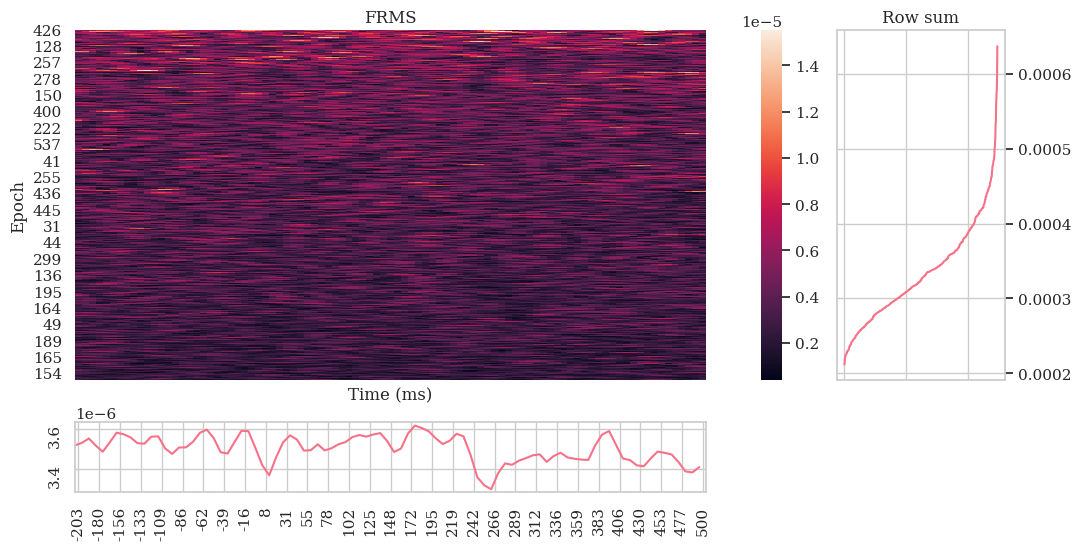

In [40]:
epochs_denoised = xd.apply(epochs)
plot_fmrs(field_root_mean_square(epochs_denoised["Target"]))

[Text(0.5, 0, 'Time (ms)'),
 Text(0, 0.5, 'GFP (µV)'),
 Text(0.5, 1.0, 'Global Field Power')]

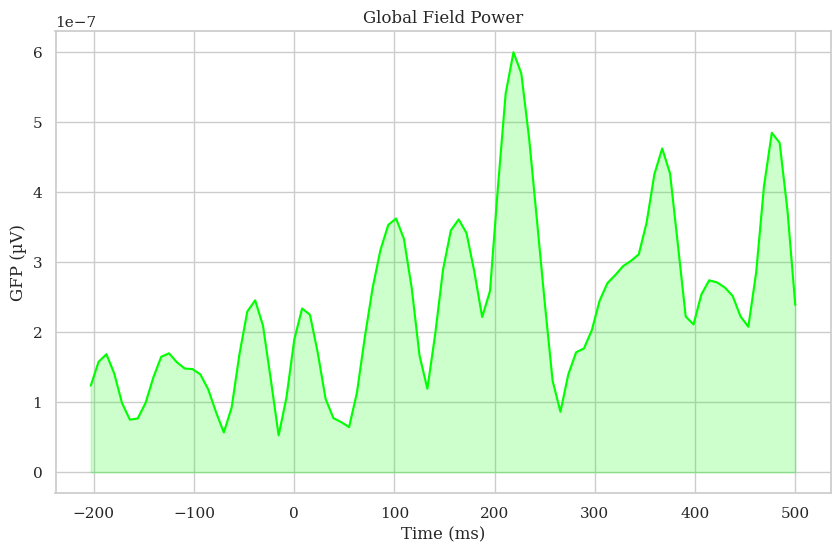

In [43]:
# Calculate Global Field Power and plot it with reference points
gfp = epochs_denoised["Target"].average().data.std(axis=0, ddof=0)

# Visualize GFP
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(target.times * 1000, gfp , color="lime")
ax.fill_between(epochs_denoised["Target"].times * 1000, gfp, color="lime", alpha=0.2)
ax.set(xlabel="Time (ms)", ylabel="GFP (µV)", title="Global Field Power")